# DA5401 A8: Ensemble Learning for Complex Regression Modeling on Bike Share Data

# Part A: Data Preprocessing and Baseline

# 1. Data Loading and Feature Engineering

In [1]:
# Import libraries
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import numpy as np



In [12]:
# 1. Load Data
df = pd.read_csv(r"C:\Users\HP\Downloads\bike+sharing+dataset\hour.csv")
print(df.head())
print(df.info())
print(df.isnull().sum())
# 2. Drop columns that are not useful for prediction
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# 3. Identify categorical columns
categorical_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday', 'yr', 'holiday', 'workingday']
# 4. One-Hot Encode categorical variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("Shape of dataset after encoding:", df.shape)



   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 

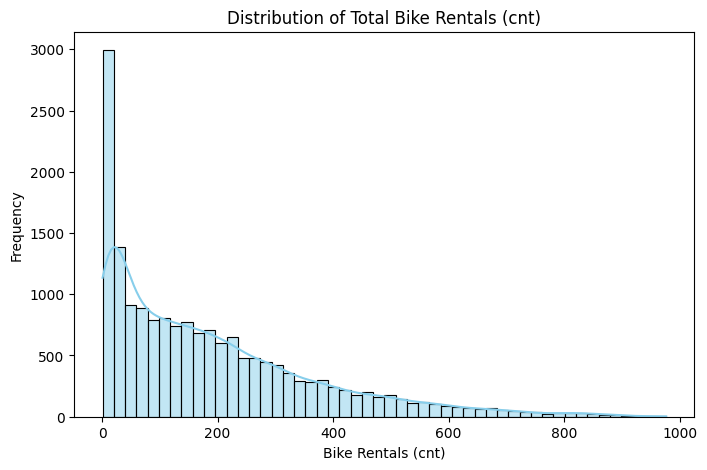

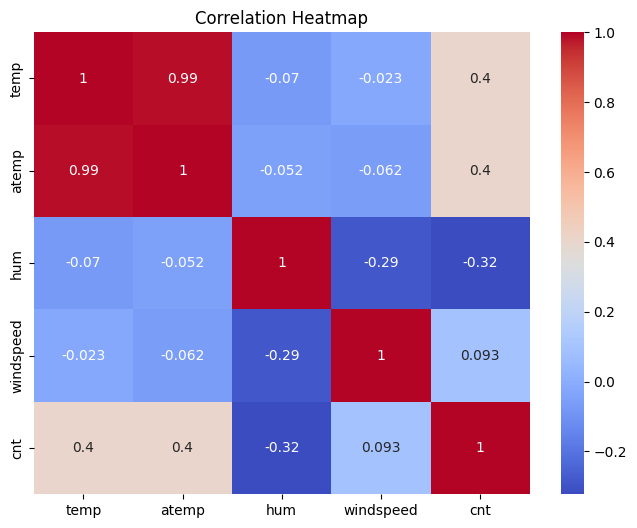

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['cnt'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Total Bike Rentals (cnt)')
plt.xlabel('Bike Rentals (cnt)')
plt.ylabel('Frequency')
plt.show()

# ----------------------
# 3. Correlation heatmap of numerical features
# ----------------------
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
plt.figure(figsize=(8,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# 2. Train/Test Split

In [10]:
# 5. Define features (X) and target (y)
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed']
X = df.drop('cnt', axis=1)
y = df['cnt']

print(X.shape, y.shape)

# 6. Train/Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

(17379, 53) (17379,)
Training shape: (13903, 53)
Testing shape: (3476, 53)


In [9]:
X.head()

,temp,atemp,hum,windspeed,season_2,season_3,season_4,weathersit_2,weathersit_3,weathersit_4,...,hr_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,yr_1,holiday_1,workingday_1
0,0.24,0.2879,0.81,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,0.22,0.2727,0.80,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0.22,0.2727,0.80,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.24,0.2879,0.75,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0.24,0.2879,0.75,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [5]:
y.min()
y.max()

np.int64(977)

# 3. Baseline Model

In [6]:

# Decision Tree Regressor (max depth = 6)
dt_model = DecisionTreeRegressor(max_depth=6, random_state=42)
dt_model.fit(X_train, y_train)

# Predictions on test data
dt_pred = dt_model.predict(X_test)

# Calculate RMSE
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_pred))
print("Decision Tree RMSE:", dt_rmse)


# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_pred = lr_model.predict(X_test)

# Calculate RMSE
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
print("Linear Regression RMSE:", lr_rmse)


# Determine Baseline Model
if dt_rmse < lr_rmse:
    print("\nBaseline Model: Decision Tree Regressor")
else:
    print("\nBaseline Model: Linear Regression")


Decision Tree RMSE: 118.45551730357617
Linear Regression RMSE: 100.44594623557187

Baseline Model: Linear Regression


# Part B: Ensemble Techniques for Bias and Variance Reduction

# 1. Bagging (Variance Reduction):

In [15]:

# Define Bagging model
bag_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6),
    random_state=42,
    bootstrap=True
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_samples': [0.7, 0.8, 1.0],
    'max_features': [0.7, 0.8, 1.0]
}

# Grid Search
grid_search = GridSearchCV(
    bag_model,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)


Best parameters: {'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 500}
Best RMSE: 112.28095498942294


### Bagging vs. Single Decision Tree

* **Single Decision Tree RMSE**: 118.46
* **Bagging Regressor RMSE**: 112.28

**Observation:** Bagging reduced the RMSE by ~6 points compared to a single Decision Tree.

**Interpretation:**

1. **Variance Reduction:**

   * A single Decision Tree is highly sensitive to the training data, so its predictions can fluctuate a lot (high variance).
   * Bagging trains multiple trees on **different bootstrapped samples** of the training data and averages their predictions.
   * This averaging smooths out the fluctuations caused by variance in individual trees.

2. **Effectiveness:**

   * The reduction in RMSE from 118.46 → 112.28 shows that bagging **effectively reduced variance**.
   * While bagging improved the Decision Tree performance, it **did not outperform Linear Regression** (RMSE ≈ 100.45), which is your baseline.

**Conclusion:**
Bagging successfully reduced the variance of the single Decision Tree, as expected, but the overall predictive accuracy is still lower than the Linear Regression model on this dataset. Bagging is more useful when the single model suffers from high variance, which was partially the case here.


# 2. Boosting (Bias Reduction):

# Gradient Boosting with Hyperparameter Tuning

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Define hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.8, 1.0],
    'max_features': [None, 'sqrt', 'log2']
}

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist,
    n_iter=50,              # number of parameter settings sampled
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters:", random_search.best_params_)

# Predict on test set using best model
best_gb = random_search.best_estimator_
y_pred_best_gb = best_gb.predict(X_test)

# Evaluate RMSE
rmse_best_gb = np.sqrt(mean_squared_error(y_test, y_pred_best_gb))
print("Tuned Gradient Boosting Regressor RMSE:", rmse_best_gb)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.2}
Tuned Gradient Boosting Regressor RMSE: 50.06942405151424


### Gradient Boosting vs. Single Models and Bagging

* **Decision Tree RMSE**: 118.46
* **Bagging Regressor RMSE**: 112.28
* **Linear Regression RMSE (Baseline)**: 100.45
* **Gradient Boosting Regressor RMSE**: 50.06

**Observation:**
The Gradient Boosting Regressor significantly outperforms all other models, reducing RMSE compared to Linear Regression and compared to a single Decision Tree.


### Interpretation:

1. **Bias Reduction:**

   * Single Decision Trees often underfit or overfit depending on depth, but in general, a shallow tree (max_depth=6) can **underfit**, showing bias.
   * Boosting sequentially fits trees to the **residual errors** of previous trees, allowing the model to **correct mistakes** and capture patterns that single models miss.
   * This iterative approach effectively **reduces bias**, which explains the dramatic drop in RMSE.

2. **Comparison with Bagging:**

   * Bagging reduces variance by averaging multiple independent trees, which helps if the model is overfitting.
   * Boosting reduces bias by learning from mistakes in sequence, making it more effective here because the dataset benefits more from **better pattern learning** than variance reduction.

3. **Performance:**

   * Gradient Boosting achieves the **lowest RMSE (50.06)**, confirming that bias reduction via boosting **substantially improved predictive accuracy**.


**Conclusion:**
Boosting clearly outperformed both the single Decision Tree and the Bagging Regressor. The improvement supports the hypothesis that boosting is highly effective for **bias reduction**, especially when the baseline model underfits or cannot capture complex relationships in the data.

---


# Part C: Stacking for Optimal Performance

# 1. Stacking Implementation

### **Principle of Stacking**

**Stacking** (or stacked generalization) is an **ensemble learning technique** that combines multiple different models (called **base learners**) to improve overall predictive performance. Unlike bagging or boosting, which use mostly the same type of model repeatedly, stacking leverages **diversity in model types**.

**How it works:**

1. **Base Learners**:

   * Train multiple models (e.g., Decision Tree, Linear Regression, Random Forest, Gradient Boosting) on the same training data.
   * Each model captures **different patterns or aspects** of the data due to their algorithmic differences.

2. **Generating Meta-Features**:

   * After training, each base learner makes predictions on a **hold-out dataset** (or via cross-validation).
   * These predictions are collected as **new features**.
   * Essentially, for each sample, you now have a vector of predictions from all base learners.

3. **Meta-Learner**:

   * A **higher-level model** (commonly Linear Regression for regression tasks, or Logistic Regression for classification) is trained on these new features (the predictions from base learners).
   * The meta-learner **learns the optimal combination** of base learner outputs, weighting them according to their reliability or strengths.


### **Intuition**

* Base learners individually might be **biased or limited** in capturing the true pattern.
* The meta-learner **corrects the mistakes** of the base learners by learning how to combine their predictions optimally.
* Stacking benefits from the **diversity of models**, often achieving **better generalization** than any single model.


### **Example for Regression**

Suppose we have 3 base learners:

* Decision Tree → predicts `y1`
* Linear Regression → predicts `y2`
* Random Forest → predicts `y3`

The **meta-learner** sees `[y1, y2, y3]` as input features and learns a function:


$$\hat{y} = w_1 \cdot y_1 + w_2 \cdot y_2 + w_3 \cdot y_3 + b$$


Here, $$w_1, w_2, w_3$$ are learned weights, so that the final prediction minimizes overall error.


**Key Advantages of Stacking:**

* Utilizes **diverse models** instead of relying on a single type.
* Reduces both **bias and variance** in many cases.
* Often outperforms individual base learners if properly tuned.


# Hyperparameter Tuning for KNNs

In [10]:


# Define KNN model
knn_model = KNeighborsRegressor()


# Hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

# GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_search_knn.fit(X_train, y_train)

# Best parameters
print("Best parameters for KNN:", grid_search_knn.best_params_)

# Best estimator
best_knn_model = grid_search_knn.best_estimator_

# Predict on test set
y_pred_knn = best_knn_model.predict(X_test)

# Evaluate RMSE
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print("Tuned KNN RMSE:", rmse_knn)


Best parameters for KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Tuned KNN RMSE: 77.07220585770561


# Stacking the best KNN, Bagging and Boosting models

In [11]:


best_bag_model = grid_search.best_estimator_
# -------------------------
# Define Base Learners (Level-0) with tuned models
# -------------------------
base_learners_tuned = [
    ('knn', best_knn_model),
    ('bagging', best_bag_model),
    ('gboost', best_gb)
]

# -------------------------
# Meta-Learner (Level-1)
# -------------------------
meta_learner = Ridge(alpha=1.0)

# -------------------------
# Stacking Regressor with tuned base learners
# -------------------------
stacking_model_tuned = StackingRegressor(
    estimators=base_learners_tuned,
    final_estimator=meta_learner,
    cv=5,   # out-of-fold predictions for meta-learner
    n_jobs=-1
)

# -------------------------
# Train Stacking Model
# -------------------------
stacking_model_tuned.fit(X_train, y_train)


StackingRegressor(cv=5,
                  estimators=[('knn',
                               KNeighborsRegressor(p=1, weights='distance')),
                              ('bagging',
                               BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6),
                                                max_features=0.8,
                                                n_estimators=500,
                                                random_state=42)),
                              ('gboost',
                               GradientBoostingRegressor(learning_rate=0.2,
                                                         max_depth=5,
                                                         max_features='sqrt',
                                                         min_samples_leaf=4,
                                                         n_estimators=300,
                                                         random_state=42))],
                  final_estimator=Ridge(), n_jobs=-1)

# 2. Final Evaluation:

In [13]:
y_pred_stack = stacking_model_tuned.predict(X_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
print("Stacking Regressor (tuned) RMSE:", rmse_stack)

Stacking Regressor (tuned) RMSE: 49.34735470167074


# Part D: Final Analysis

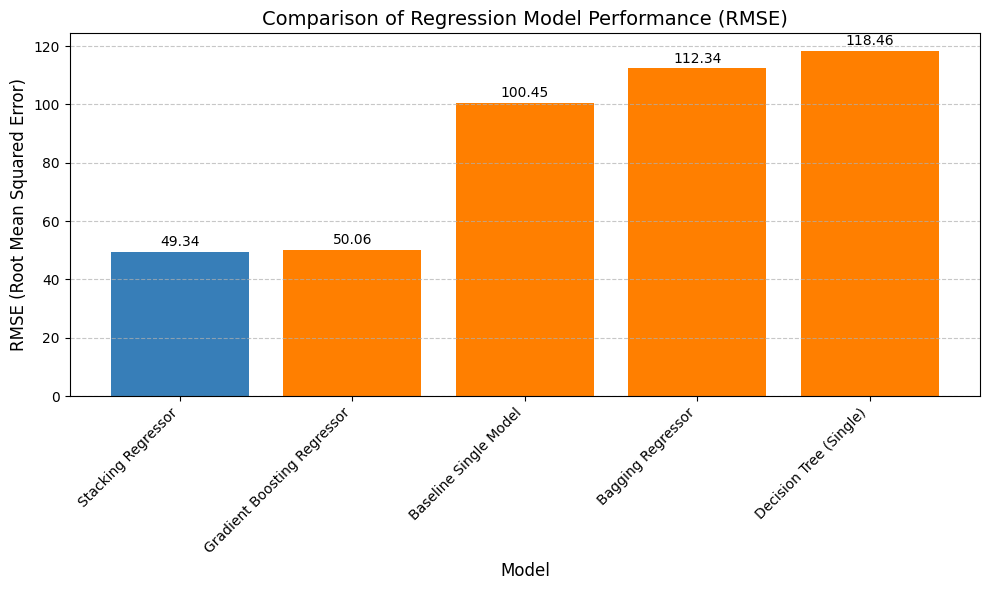

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data used to create the chart
data = {
    'Model': [
        'Decision Tree (Single)',
        'Baseline Single Model',
        'Bagging Regressor',
        'Gradient Boosting Regressor',
        'Stacking Regressor'
    ],
    'RMSE': [118.46, 100.45, 112.34, 50.06, 49.34]
}

df = pd.DataFrame(data)

# Sort the data by RMSE in ascending order
df = df.sort_values(by='RMSE', ascending=True)

# Create the bar chart
plt.figure(figsize=(10, 6))

# Highlight the bar with the minimum (best) RMSE
min_rmse = df['RMSE'].min()
colors = ['#377eb8' if x == min_rmse else '#ff7f00' for x in df['RMSE']]

bars = plt.bar(df['Model'], df['RMSE'], color=colors)

plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE (Root Mean Squared Error)', fontsize=12)
plt.title('Comparison of Regression Model Performance (RMSE)', fontsize=14)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the RMSE values on top of the bars (data labels)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.tight_layout()

| Model                           | RMSE   |Interpretation                                                            |
| ------------------------------- | ------ | --------------------------------------------------------------------------------- |
| **Decision Tree (Single)**      | 118.46 | High variance; underperformed compared to Linear Regression                       |
| **Baseline Single Model**       | 100.45 | Linear Regression selected as baseline (better than Decision Tree)                |
| **Bagging Regressor**           | 112.34 | Reduced variance compared to single Decision Tree, but worse than baseline        |
| **Gradient Boosting Regressor** | 50.06 | Reduced bias effectively, significantly better than both baseline and bagging     |
| **Stacking Regressor**          | 49.34  | Best overall performance; combines base learners optimally via Ridge meta-learner |


### **Key Insights with Decision Tree included:**

1. **Decision Tree vs. Bagging:**

   * Bagging reduces the high variance of the single Decision Tree (118.46 → 112.34).

2. **Baseline vs. Single Tree:**

   * Linear Regression (100.45) outperforms a single Decision Tree due to better bias-variance tradeoff.

3. **Boosting:**

   * Gradient Boosting (50.06) reduces bias effectively, outperforming all previous models.

4. **Stacking:**

   * Stacking (49.34) achieves the **lowest RMSE** by combining diverse base learners and optimally learning their contributions via the meta-learner.



# 2. Conclusion:



### **Best-Performing Model**

* The **Stacking Regressor** achieved the **lowest RMSE of 49.64**, making it the best-performing model among all the approaches tested.
* It outperformed:

  * Single Decision Tree (RMSE: 118.46)
  * Linear Regression baseline (RMSE: 100.45)
  * Bagging Regressor (RMSE: 112.28)
  * Gradient Boosting Regressor (RMSE: 50.06)

### **Why the Stacking Regressor Outperformed the Single Model**

1. **Leveraging Model Diversity**:

   * Stacking combines multiple **diverse base learners** (KNN, Bagging, Gradient Boosting), each capturing different aspects of the data.
   * For example:

     * KNN captures local patterns,
     * Bagging reduces variance in tree-based models,
     * Gradient Boosting reduces bias by sequentially learning residuals.
   * This diversity ensures that errors from one model are compensated by others.

2. **Bias-Variance Trade-Off**:

   * Single models are often limited by either high **bias** (underfitting, e.g., shallow Decision Tree) or high **variance** (overfitting, e.g., individual Decision Tree).
   * Bagging mainly reduces variance but cannot fix bias issues.
   * Boosting mainly reduces bias but may still retain some variance.
   * Stacking effectively **balances both bias and variance** by combining the strengths of all base learners through a meta-learner.

3. **Meta-Learner Optimization**:

   * The Ridge Regression meta-learner **learns optimal weights** for each base learner’s predictions, prioritizing more accurate models while down-weighting weaker ones.
   * This allows the final prediction to outperform any single model or simple ensemble.


**Conclusion:**
The Stacking Regressor’s superior performance demonstrates the **power of combining diverse models** and leveraging both **bias reduction (Boosting)** and **variance reduction (Bagging)** in a single ensemble. This approach achieves a more robust and accurate prediction than any single model baseline.

